In [1]:
import os, sys
sys.path.append('../')
from osqtoolz import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import seaborn as sns
import tldextract
from urllib.parse import urlparse
import math
%matplotlib inline
train = pd.read_csv('./data/train.csv')
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [2]:
checkna(train)

2797/3000 (93%) rows contain NaNs, in 13 columns:
id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0


In [3]:
import tldextract
from urllib.parse import urlparse
import math

def homepage_func(x):
    if type(x) == str:
        x1 = tldextract.extract(x)
        x2 = urlparse(x)
        return 'domain_{}'.format(x1[1]), len([i for i in x2[2].split('/') if len(i) > 0])
    elif np.isnan(x):
        return 'domain_no_value', 0
    else:
        raise Exception('weird value', x)
tmp = train['homepage'].apply(homepage_func)
domains = pd.Series([i[0] for i in tmp])
subcount = pd.Series([i[1] for i in tmp])
domain_counts = pd.Series(domains).value_counts()
def domain_freq(x):
    if domain_counts[x] == 1:
        return 'domain_lone_value'
    else:
        return x
train['domain'] = domains.apply(domain_freq)
train = pd.concat([pd.get_dummies(train.domain), train.drop('domain', axis=1)], axis=1)

langs = set()
def lang_func(x):
    try:
        out = [x['name'].lower() for x in json.loads(x.replace("'", '"'))]
        out = [x for x in out if x not in ['no language', '']]
        langs.update(out)
        return out
    except:
        return []
def json_func(x):
    try:
        return 'coll_{}'.format(json.loads(x.replace("'", '"'))[0]['name'].lower())
    except:
        return np.nan
lang_series = train.spoken_languages.apply(lang_func)
train.drop(['spoken_languages'], axis=1, inplace=True)
for lang in langs:
    train['lang_{}'.format(lang)] = lang_series.apply(lambda x: np.uint8(1) if lang in x else np.uint8(0)).astype(np.uint8)
train.belongs_to_collection = train.belongs_to_collection.apply(json_func)
value_counts = train.belongs_to_collection.dropna().value_counts()
def count_func(x):
    if type(x) == str:
        if value_counts[x] > 1:
            return x
        else:
            return ''
    elif np.isnan(x):
        return ''
    else:
        raise Exception("Unknown value", x)
train.belongs_to_collection = train.belongs_to_collection.apply(count_func)
train = pd.concat([pd.get_dummies(train.belongs_to_collection), train.drop('belongs_to_collection', axis=1)], axis=1)
train['num_id'] = train.imdb_id.apply(lambda x: int(x[2:]))
train['name_len'] = train.original_title.apply(lambda x: len(x))
train['name_len'] = train.original_title.apply(lambda x: len(x) if type(x) == str else x)
name_len_mean = int(math.ceil(train.name_len.mean()))
train['name_len'] = train.name_len.apply(lambda x: name_len_mean if np.isnan(x) else x)
train.original_language = train.original_language.apply(lambda x: 'orig_lang_{}'.format(x))
train = pd.concat([pd.get_dummies(train.original_language), train.drop(['original_language'], axis=1)], axis=1)
train['status_int'] = train.status.apply(lambda x: 1 if x == 'Released' else 0)
train.runtime = train.runtime.apply(lambda x: train.runtime.mean() if np.isnan(x) else x)
train = train.drop(['original_title', 'imdb_id', 'cast', 'crew', 'Keywords', 'title', 'tagline', 'status', 'genres', 'homepage', 'id', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date'], axis=1)
train.head()

,orig_lang_ar,orig_lang_bn,orig_lang_cn,orig_lang_cs,orig_lang_da,orig_lang_de,orig_lang_el,orig_lang_en,orig_lang_es,orig_lang_fa,...,lang_esperanto,lang_český,lang_پښتو,lang_gaeilge,lang_తెలుగు,lang_日本語,lang_svenska,num_id,name_len,status_int
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2637294,22,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,368933,40,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2582802,8,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1821480,7,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1380152,4,1


In [4]:
import catboost as ctb
from sklearn.linear_model import RidgeCV
cat = ctb.CatBoostRegressor(verbose=False, loss_function="RMSE")
rcv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=5)

In [7]:
train = train.sample(frac=1)
X_train = train.drop('revenue', axis=1).values
y_train = np.log1p(train.revenue.values)

R2: 0.13805269541321086
RMSLE: 2.0952277521123697


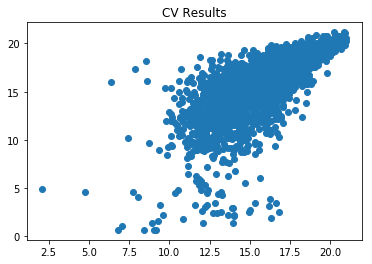

In [8]:
train_regressor(cat, X_train, y_train)